# DEMO: Running FastCAM using SMOE Scale Saliency Maps

## Initial code setup

First we set up compatibility between Python2 and 3 then import various libraries. 

Some possible issues:

    If you get:
        cannot import name ‘PILLOW_VERSION’
    This is a known weird issue between Pillow and Torchvision, install an older version as such:
        pip install pillow=6.2.1

In [1]:
from __future__ import print_function, division, absolute_import

import cv2
import numpy as np
import torch.utils.data
import torch.cuda
from torchvision import models, transforms
from IPython.display import Image


Lets load things we need for **Grad-CAM**

We may need to set env for the python gradcam library. An *example path*:

    PYTHONPATH=$PYTHONPATH:/Users/mundhenk1/Source/fastcam/venv_fastcam/lib/python3.7/site-packages/
    
Then we import the libraries we need to run it

In [2]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

from gradcam.utils import visualize_cam, Normalize
from gradcam import GradCAMpp

import os

Now we import the code for *this package*.

In [3]:
import maps
import mask
import draw
import misc

This is where we can set some parameters like the image name and the layer weights.

In [4]:
input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process                        
output_dir          = 'outputs'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from
weights             = [0.18, 0.15, 0.37, 0.4, 0.72]             # Our saliency layer weights (From paper)

save_prefix         = input_image_name[:-4].split('/')[-1]
load_image_name     = os.path.join(input_dir, input_image_name)

os.makedirs(output_dir, exist_ok=True)

Good Doggy!

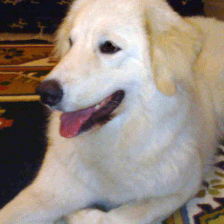

In [5]:
Image(filename=load_image_name) 

Now we create a model in PyTorch and send it to our device. In this case, the GPU is available. 

In [6]:
device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model               = models.resnet50(pretrained=True)
model               = model.to(device)

## Setting up Hooks
Now we will set up our layer hooks as callback methods. This will keep a copy of a layers output data from a forward pass. This is how we will get the data out of the networks layers. 

So, lets look at the second spatial scale of ResNet which has three bottleneck layers. We want that very last ReLU at the very end. 

In [7]:
print("{}".format(model.layer1))

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

So we would select 

    model.layer1[2].relu
    
with a command like

    model.layer1[2].relu.register_forward_hook(hooks[1]) 
    
This attaches a callback which will store this layers output, when the network is run. 

Below we attach a hook at the end of each spatial scale. 

In [8]:
hooks   = [ misc.CaptureLayerOutput() for i in range(5)]  # Create 5 callback hooks in a list
map_num = len(hooks) 

model.relu.register_forward_hook(hooks[0])
model.layer1[2].relu.register_forward_hook(hooks[1])
model.layer2[3].relu.register_forward_hook(hooks[2])
model.layer3[5].relu.register_forward_hook(hooks[3])
model.layer4[2].relu.register_forward_hook(hooks[4])

Notice that the layers we access are the same as in the resnet50 python model layers specificiation which is **[3, 4, 6, 3]**, we just subtract 1 from each. 

OK, now lets load in our image and set it to 224x224. 

In [9]:
in_tensor   = misc.LoadImageToTensor(load_image_name, device)
in_tensor   = F.interpolate(in_tensor, size=(224, 224), mode='bilinear', align_corners=False)

in_height   = in_tensor.size()[2]
in_width    = in_tensor.size()[3]

OK, lets run our ResNet network *forward only*. The callbacks will then contain the layer data afterwards. Since we are only doing a forward computation, this sails on a CPU. 

In [10]:
model.eval()
with torch.set_grad_enabled(False):
    _  = model(in_tensor)

## Running saliency on our network data

Now that the network has run, we can finally do some work. First we create objects for our saliency layers. These are PyTorch nn layers, but we can talk to them even if they are not inside a network. 

All three objects here are technically layers. So, they can be used inside your network as well. 

If you want to use these **inside your network**:

example, in your __init__ something like:

    self.salmap_layer     = maps.SMOEScaleMap()

then in forward(x) something like:

    x = self.relu(x)
    x = self.salmap_layer(x)

In [11]:
getSmap     = maps.SMOEScaleMap()                                   
getNorm     = maps.Normalize2D()                                    
getCsmap    = maps.CombineSaliencyMaps(output_size=[in_height,in_width], 
                                       map_num=map_num, weights=weights, resize_mode='bilinear') 

Once we have our objects, we will run SMOE Scale on each of the output hooks and then normalize the output. 

In [12]:
smaps       = [ getNorm(getSmap(x.data)) for x in hooks ]           

Now, we combine the different saliency maps into a single combined saliency map. Then we save it.

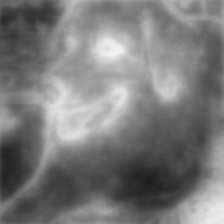

In [13]:
csmap,smaps = getCsmap(smaps)
output_name = "{}.MAP_COMBINED.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
misc.SaveGrayTensorToImage(csmap, output_path)
np_smaps    = misc.TensorToNumpyImages(smaps) # For later use

Image(filename=output_path) 

Now lets get our individual saliency maps for each of the five layers and look at them. 

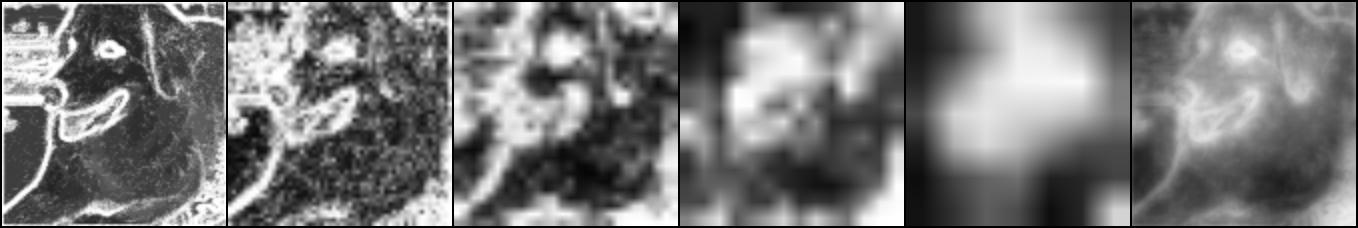

In [14]:
il = [smaps[0,i,:,:] for i in range(map_num)]
    
il.append(csmap[0,:,:])    # add in the combined map at the end

images        = [torch.stack(il, 0)]
images        = make_grid(torch.cat(images, 0), nrow=5)
output_name   = "{}.SAL_MAPS.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)

save_image(images.unsqueeze(1), output_path)

Image(filename=output_path) 

## LOVI and Heat Maps
Now we will take our saliency maps and create the LOVI and Heat Map versions.

In [15]:
SHM         = draw.HeatMap(shape=np_smaps.shape, weights=weights )  # Create our heat map drawer
LOVI        = draw.LOVI(shape=np_smaps.shape, weights=None)         # Create out LOVI drawer
shm_im      = SHM.make(np_smaps)                                    # Combine the saliency maps into one heat map
lovi_im     = LOVI.make(np_smaps)                                   # Combine the saliency maps into one LOVI image

Next, save and display our images. 

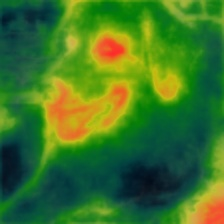

In [16]:
output_name = "{}.HEAT.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (shm_im*255.0).astype(np.uint8))

Image(filename=output_path) 

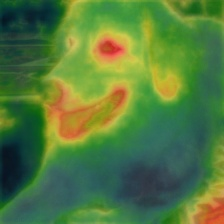

In [17]:
cv_im         = cv2.imread(load_image_name).astype(np.float32) / 255.0
cv_im         = cv2.resize(cv_im, (224,224))
ab_shm        = misc.AlphaBlend(shm_im, cv_im)

output_name   = "{}.ALPHA_HEAT.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_shm*255.0).astype(np.uint8)) 

Image(filename=output_path) 

Now we view our LOVI map with and without alpha blending of the original image.

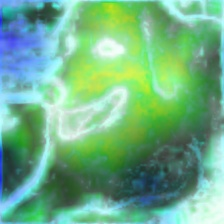

In [18]:
output_name   = "{}.LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (lovi_im*255.0).astype(np.uint8))

Image(filename=output_path) 

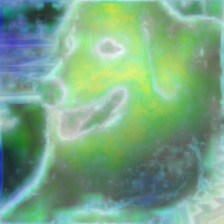

In [19]:
ab_lovi       = misc.AlphaBlend(lovi_im,cv_im)

output_name   = "{}.ALPHA_LOVI.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
cv2.imwrite(output_path, (ab_lovi*255.0).astype(np.uint8)) 

Image(filename=output_path) 

## The Masked Image
From the combined saliency map, we can extract the masked out input image. 

First we set up objects to create the mask from the input tensor version of the image and the combined saliency map.

In [20]:
getMask                 = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)
denorm                  = misc.DeNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Next we process the tensor and saliency map to create the masked image.  

In [21]:
masked_tensor,drop_map        = getMask(in_tensor, csmap)

Finally, we denormalize the tensor image, save and display it. This shows us the **top 10% most salient parts** of the images.

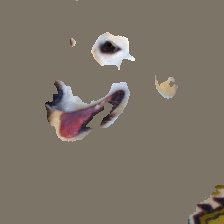

In [22]:
masked_tensor    = denorm(masked_tensor)

output_name   = "{}.MASK.jpg".format(save_prefix)
output_path   = os.path.join(output_dir, output_name)
misc.SaveColorTensorToImage(masked_tensor, output_path)
Image(filename=output_path) 

## Run With Grad-CAM++

Lets go ahead and push our model into the Grad-CAM library.

**NOTE** much of this code is borrowed from the Pytorch GradCAM package. 

In [23]:
resnet_gradcampp4   = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

Lets get our image back here.

In [24]:
raw_tensor   = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor   = F.interpolate(raw_tensor, size=(224, 224), mode='bilinear', align_corners=False)

Lets put the SMOE Scale based saliency map into the same format we will use for Grad-CAM.

In [25]:
norm     = maps.Normalize2D()
csmap    = (csmap - torch.min(csmap)) / (torch.max(csmap) - torch.min(csmap))

masked_tensor_raw,drop_map = getMask(raw_tensor, csmap)

cs_heatmap, cs_result      = visualize_cam(csmap, raw_tensor)
cs_masked                  = misc.AlphaMask(raw_tensor, torch.pow(csmap,2)).squeeze(0)
cs_masked                  = (cs_masked - torch.min(cs_masked)) / (torch.max(cs_masked) - torch.min(cs_masked))

images = []
images.append(torch.stack([raw_tensor.squeeze().cpu(), cs_heatmap, 
                           cs_result, cs_masked, masked_tensor_raw[0,]], 0))

Now, lets get the Grad-CAM++ saliency map only.

In [26]:
mask_pp1, _             = resnet_gradcampp4(in_tensor)
heatmap_pp1, result_pp1 = visualize_cam(mask_pp1, raw_tensor)

hard_masked_pp1,_       = getMask(raw_tensor, mask_pp1.squeeze(0))
hard_masked_pp1         = hard_masked_pp1.squeeze(0)
masked_pp1              = misc.AlphaMask(raw_tensor, torch.pow(mask_pp1.squeeze(0),2)).squeeze(0)
masked_pp1              = (masked_pp1 - torch.min(masked_pp1)) / (torch.max(masked_pp1) - torch.min(masked_pp1))

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp1, 
                           result_pp1, masked_pp1, hard_masked_pp1], 0))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Now we combine the Grad-CAM map and the SMOE Scale saliency maps in the same way we would combine Grad-CAM with Guided Backprop.

In [27]:
mask_pp2                = csmap*mask_pp1
heatmap_pp2, result_pp2 = visualize_cam(mask_pp2, raw_tensor)

hard_masked_pp2,_       = getMask(raw_tensor,mask_pp2.squeeze(0))
hard_masked_pp2         = hard_masked_pp2.squeeze(0)
masked_pp2              = misc.AlphaMask(raw_tensor, torch.pow(mask_pp2.squeeze(0),2)).squeeze(0)
masked_pp2              = (masked_pp2 - torch.min(masked_pp2)) / (torch.max(masked_pp2) - torch.min(masked_pp2))

images.append(torch.stack([raw_tensor.squeeze().cpu(), heatmap_pp2, 
                           result_pp2, masked_pp2, hard_masked_pp2], 0))

We now put all the images into a nice grid for display.

In [28]:
images = make_grid(torch.cat(images,0), nrow=5)

... save and look at it. 

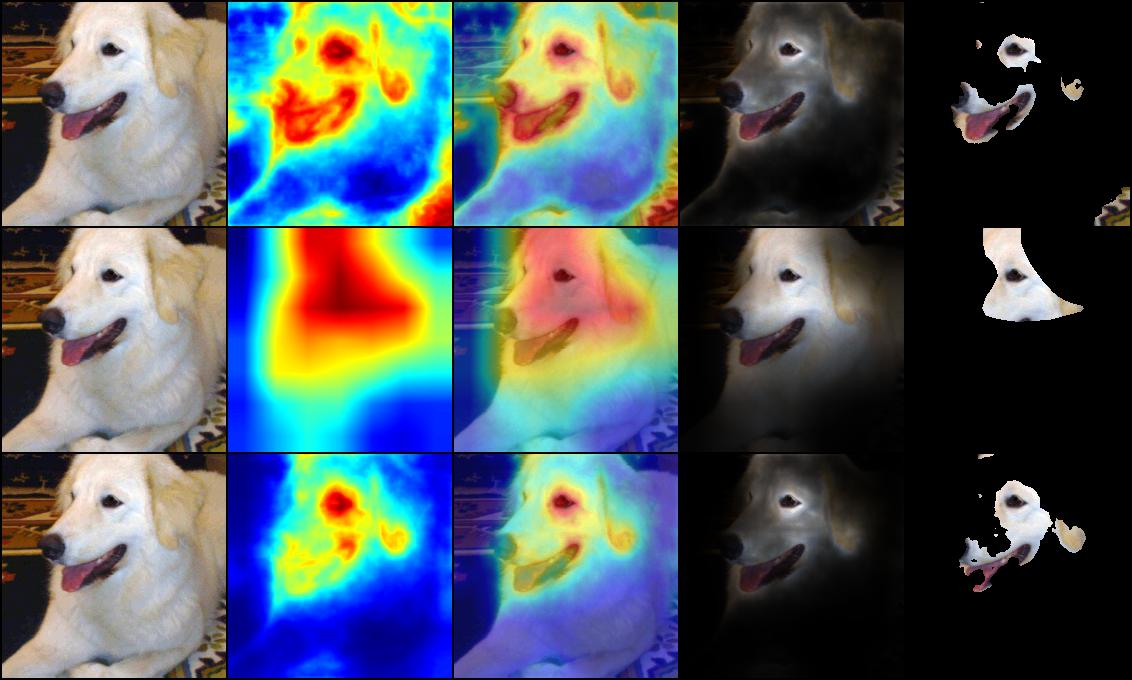

In [29]:
output_name = "{}.CAM_PP.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 

The top row is the SMOE Scale based saliency map. The second row is GradCAM++ only. Finally we have the FastCAM output from combining the two. 